In [1]:
import sys
import math
import covid
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import chisquare, chi2_contingency
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set()
plt.style.use('seaborn-darkgrid')
pd.options.display.float_format = '{:,.2f}'.format

### Reading data from John Hopkins CSSE repo

In [2]:
confirmed_raw = pd.read_csv(covid.global_confirmed)
deaths_raw = pd.read_csv(covid.global_deaths)
recoveries_raw = pd.read_csv(covid.global_recoveries)

### Cleaning data from unused fields and transposing

In [3]:
confirmed = covid.clean_data(confirmed_raw)
deaths = covid.clean_data(deaths_raw)
recoveries = covid.clean_data(recoveries_raw)

In [4]:
confirmed_by_country = covid.country_data(confirmed, 'confirmed')
deaths_by_country = covid.country_data(deaths, 'deaths')
recoveries_by_country = covid.country_data(recoveries, 'recoveries')
dates_in_dataset = confirmed_by_country.index.levels[1]

### Calculating delta with previous days

In [5]:
new_confirmed_by_country = covid.daily_data(confirmed_by_country, 'confirmed','new_confirmed')
new_deaths_by_country = covid.daily_data(deaths_by_country, 'deaths', 'new_deaths')
new_recoveries_by_country = covid.daily_data(recoveries_by_country, 'recoveries', 'new_recoveries')

### Consolidating data and calculating rolling averages

In [6]:
dataframes_by_country = pd.concat([confirmed_by_country, deaths_by_country, recoveries_by_country, 
                  new_confirmed_by_country, new_deaths_by_country, new_recoveries_by_country], axis=1)
global_total = dataframes_by_country.reset_index().groupby('date').sum().copy()
consolidated = covid.calc_averages(dataframes_by_country)

### Selecting a single country from the dataset (two weeks view)

In [7]:
consolidated.loc['United Kingdom'][::-1][0:14]

,confirmed,deaths,recoveries,new_confirmed,new_deaths,new_recoveries,roll_confirmed,roll_deaths,pct_recoveries,deaths_ratio
date,,,,,,,,,,
2020-08-11,"313,394.00","46,611.00","1,464.00",2.00,0.00,1.00,781.14,42.43,0.03,0.15
2020-08-10,"313,392.00","46,611.00","1,463.00",818.00,-48.00,12.00,877.29,45.14,0.03,0.15
2020-08-09,"312,574.00","46,659.00","1,451.00","1,113.00",8.00,2.00,895.00,53.29,0.03,0.15
2020-08-08,"311,461.00","46,651.00","1,449.00",765.00,55.00,2.00,842.71,53.29,0.03,0.15
2020-08-07,"310,696.00","46,596.00","1,447.00",900.00,98.00,0.00,843.29,56.00,0.03,0.15
2020-08-06,"309,796.00","46,498.00","1,447.00",964.00,49.00,1.00,840.86,59.14,0.03,0.15
2020-08-05,"308,832.00","46,449.00","1,446.00",906.00,135.00,1.00,824.14,57.57,0.03,0.15
2020-08-04,"307,926.00","46,314.00","1,445.00",675.00,19.00,0.00,809.29,50.14,0.03,0.15
2020-08-03,"307,251.00","46,295.00","1,445.00",942.00,9.00,1.00,791.86,64.43,0.03,0.15


### Global totals from the last two weeks

In [8]:
global_total.iloc[-14:][::-1]

,confirmed,deaths,recoveries,new_confirmed,new_deaths,new_recoveries
date,,,,,,
2020-08-11,"20,284,332.00","741,108.00","12,585,473.00","194,709.00","4,917.00","304,953.00"
2020-08-10,"20,089,624.00","736,191.00","12,280,520.00","227,941.00","4,865.00","164,695.00"
2020-08-09,"19,861,684.00","731,326.00","12,115,825.00","224,177.00","4,545.00","176,716.00"
2020-08-08,"19,637,506.00","726,781.00","11,939,109.00","259,470.00","5,457.00","201,182.00"
2020-08-07,"19,378,036.00","721,324.00","11,737,927.00","280,887.00","6,384.00","192,526.00"
2020-08-06,"19,097,148.00","714,940.00","11,545,401.00","285,196.00","6,516.00","189,126.00"
2020-08-05,"18,811,952.00","708,424.00","11,356,275.00","271,164.00","7,077.00","221,540.00"
2020-08-04,"18,540,788.00","701,347.00","11,134,735.00","258,581.00","6,951.00","221,735.00"
2020-08-03,"18,282,208.00","694,396.00","10,913,000.00","202,485.00","4,331.00","222,445.00"


In [9]:
top_countries_by_confirmed = consolidated.groupby('country').tail(1).reset_index(level=1, drop=True)
top_countries_by_confirmed = top_countries_by_confirmed.sort_values('confirmed', ascending=False).head(15)
top_countries_by_mortality = top_countries_by_confirmed.sort_values('deaths', ascending=False).head(15)
top_countries_list = pd.Series(top_countries_by_confirmed.index)

### Top 15 countries by infection rates

In [10]:
top_countries_by_confirmed

,confirmed,deaths,recoveries,new_confirmed,new_deaths,new_recoveries,roll_confirmed,roll_deaths,pct_recoveries,deaths_ratio
country,,,,,,,,,,
US,"5,141,208.00","164,537.00","1,714,960.00","46,808.00","1,074.00","44,205.00","52,875.43","1,007.86",0.91,0.03
Brazil,"3,057,470.00","101,752.00","2,449,338.00",0.00,0.00,"58,508.00","36,507.00",847.57,0.96,0.03
India,"2,329,638.00","46,091.00","1,639,599.00","60,963.00",834.00,"56,110.00","60,197.71",899.43,0.97,0.02
Russia,"895,691.00","15,103.00","701,796.00","4,892.00",130.00,"6,479.00","5,132.71",110.86,0.98,0.02
South Africa,"566,109.00","10,751.00","426,125.00","2,511.00",130.00,"8,925.00","6,398.71",266.71,0.98,0.02
Mexico,"492,522.00","53,929.00","397,278.00","6,686.00",926.00,"4,118.00","6,080.14",722.86,0.88,0.11
Peru,"483,133.00","21,276.00","329,404.00",0.00,0.00,"5,384.00","6,177.57",181.29,0.94,0.04
Colombia,"410,453.00","13,475.00","230,427.00","12,830.00",321.00,"8,943.00","10,782.00",308.57,0.94,0.03
Chile,"376,616.00","10,178.00","349,541.00","1,572.00",39.00,"2,199.00","1,950.57",61.86,0.97,0.03


### Overall reported mortality rate as today

In [11]:
reported_mortality_rate = top_countries_by_mortality['deaths'].sum() / top_countries_by_mortality['confirmed'].sum()
print('Overall reported mortality rate: %.2f%%' % (100.0 * reported_mortality_rate))

Overall reported mortality rate: 3.49%


### Reported Mortality Rate by Country

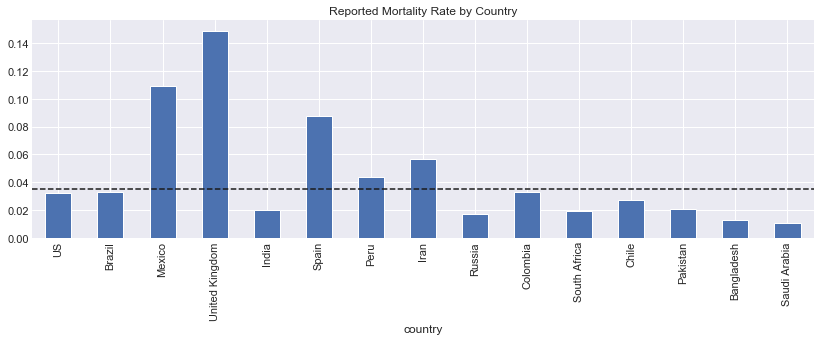

In [12]:
mortality_rate = pd.Series(data=top_countries_by_mortality['deaths_ratio'].values, index=top_countries_by_mortality.index)
ax = mortality_rate.plot.bar(figsize=(14,4), title='Reported Mortality Rate by Country')
ax.axhline(reported_mortality_rate, color='k', ls='--')
plt.show()